In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from keras.models import load_model
from tensorflow import keras
 

In [3]:
import os
def ListofFiles(Dir):
    Files = []
    for root, dir_name, file_name in os.walk(Dir): 
#root store address till directory, dir_name stores directory name # file_name stores file name
        for name in file_name:
            fullName = os.path.join(root, name)
            Files.append(fullName)
    return Files

In [4]:
a=ListofFiles(r'D:\PS\mossaic 2\MosaicPS2\indian_plates')
a

['D:\\PS\\mossaic 2\\MosaicPS2\\indian_plates\\Audi-A4-528794d.png',
 'D:\\PS\\mossaic 2\\MosaicPS2\\indian_plates\\Audi-A4-528794d_1.png',
 'D:\\PS\\mossaic 2\\MosaicPS2\\indian_plates\\Audi-A6-528818b.png',
 'D:\\PS\\mossaic 2\\MosaicPS2\\indian_plates\\BMW-3-Series-528819e.png',
 'D:\\PS\\mossaic 2\\MosaicPS2\\indian_plates\\BMW-5-Series-524359c.png',
 'D:\\PS\\mossaic 2\\MosaicPS2\\indian_plates\\BMW-X1-528026e.png',
 'D:\\PS\\mossaic 2\\MosaicPS2\\indian_plates\\BMW-X5-528820c.jpg_0000_0316_0245_0160_0037.png',
 'D:\\PS\\mossaic 2\\MosaicPS2\\indian_plates\\Chevrolet-Aveo-521114c.jpg_0004_0365_0346_0224_0065.png',
 'D:\\PS\\mossaic 2\\MosaicPS2\\indian_plates\\Chevrolet-Aveo-526315c.jpg_0357_0270_0361_0249_0087.png',
 'D:\\PS\\mossaic 2\\MosaicPS2\\indian_plates\\Chevrolet-Aveo-528299d.jpg_0000_0218_0236_0170_0052.png',
 'D:\\PS\\mossaic 2\\MosaicPS2\\indian_plates\\Chevrolet-Aveo-Old-523643b.jpg_0000_0084_0145_0087_0023.png',
 'D:\\PS\\mossaic 2\\MosaicPS2\\indian_plates\\Chevrol

In [5]:
def PlateRecognition(imagepath):
    
    plate_cascade = cv2.CascadeClassifier(r'C:\Users\Asus\Dropbox\My PC (LAPTOP-P3LNV77V)\Downloads\indian_license_plate.xml')
    def detect_plate(img, text=''): # the function detects and perfors blurring on the number plate.
        plate_img = img.copy()
        roi = img.copy()
        plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.52, minNeighbors = 2) # detects numberplates and returns the coordinates and dimensions of detected license plate's contours.
        for (x,y,w,h) in plate_rect:
            roi_ = roi[y:y+h, x:x+w, :] # extracting the Region of Interest of license plate for blurring.
            plate = roi[y:y+h, x:x+w, :]
            cv2.rectangle(plate_img, (x+2,y), (x+w-3, y+h-5), (51,181,155), 3) # finally representing the detected contours by drawing rectangles around the edges.
        if text!='':
            plate_img = cv2.putText(plate_img, text, (x-w//2,y-h//2), 
                                cv2.FONT_HERSHEY_COMPLEX_SMALL , 0.5, (51,181,155), 1, cv2.LINE_AA)
        
        return plate_img, plate # returning the processed image.
    
    
    # Testing the above function
    def display(img_, title=''):
        img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        fig = plt.figure(figsize=(10,6))
        ax = plt.subplot(111)
        ax.imshow(img)
        plt.axis('off')
        plt.title(title)
        plt.show()

        
    img = cv2.imread(imagepath)
    display(img, 'input image')
    
    
    output_img, plate = detect_plate(img)
    display(output_img, 'detected license plate in the input image')
    display(plate, 'extracted license plate from the image')
    
    
    
    # Match contours to license plate or character template
    def find_contours(dimensions, img) :

    # Find all contours in the image
        cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
        lower_width = dimensions[0]
        upper_width = dimensions[1]
        lower_height = dimensions[2]
        upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
        cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
        ii = cv2.imread('contour.jpg')
    
        x_cntr_list = []
        target_contours = []
        img_res = []
        for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
            intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
            if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
                x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

                char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
                char = img[intY:intY+intHeight, intX:intX+intWidth]
                char = cv2.resize(char, (20, 40))
            
                cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
                plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
                char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
                char_copy[2:42, 2:22] = char
                char_copy[0:2, :] = 0
                char_copy[:, 0:2] = 0
                char_copy[42:44, :] = 0
                char_copy[:, 22:24] = 0

                img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
        plt.show()
    # arbitrary function that stores sorted list of character indeces
        indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
        img_res_copy = []
        for idx in indices:
            img_res_copy.append(img_res[idx])# stores character images according to their index
        img_res = np.array(img_res_copy)

        return img_res
    
    
    def segment_characters(image) :

        # Preprocess cropped license plate image
        img_lp = cv2.resize(image, (333, 75))
        img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
        _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        img_binary_lp = cv2.erode(img_binary_lp, (3,3))
        img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

        LP_WIDTH = img_binary_lp.shape[0]
        LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
        img_binary_lp[0:3,:] = 255
        img_binary_lp[:,0:3] = 255
        img_binary_lp[72:75,:] = 255
        img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
        dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
        plt.imshow(img_binary_lp, cmap='gray')
        plt.show()
        cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
        char_list = find_contours(dimensions, img_binary_lp)

        return char_list
    
    
    char = segment_characters(plate)
    
    for i in range(len(char)):
        plt.subplot(1, len(char), i+1)
        plt.imshow(char[i], cmap='gray')
        plt.axis('off')
        
    import tensorflow.keras.backend as K
    train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
    path = r'D:\PS\mossaic 2\MosaicPS2'
    train_generator = train_datagen.flow_from_directory(
        path+'\dataset',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='sparse')

    validation_generator = train_datagen.flow_from_directory(
        path+'\dataset',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
        class_mode='sparse')
    
    
    # Metrics for checking the model performance while training
    def f1score(y, y_pred):
      return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro') 

    def custom_f1score(y, y_pred):
      return tf.py_function(f1score, (y, y_pred), tf.double)
    
    
    K.clear_session()
    model = Sequential()
    model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
    model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(4, 4)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(36, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=[custom_f1score])
    
    
    model = keras.models.load_model(r'C:\Users\Asus\Dropbox\My PC (LAPTOP-P3LNV77V)\Downloads\MosPS2\myModelpn.h5')
    # summarize model.
    model.summary()

    def fix_dimension(img): 
      new_img = np.zeros((28,28,3))
      for i in range(3):
        new_img[:,:,i] = img
      return new_img
  
    def show_results():
        dic = {}
        characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
        for i,c in enumerate(characters):
            dic[i] = c

        output = []
        for i,ch in enumerate(char): #iterating over the characters
            img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
            img = fix_dimension(img_)
            img = img.reshape(1,28,28,3) #preparing image for the model
            y_ = model.predict_classes(img)[0] #predicting the class
            character = dic[y_] #
            output.append(character) #storing the result in a list
        
        plate_number = ''.join(output)
    
        return plate_number

    print(show_results())
    
    plt.figure(figsize=(10,6))
    for i,ch in enumerate(char):
        img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        plt.subplot(3,4,i+1)
        plt.imshow(img,cmap='gray')
        plt.title(f'predicted: {show_results()[i]}')
        plt.axis('off')
    plt.show()

        
    return show_results()


    
    

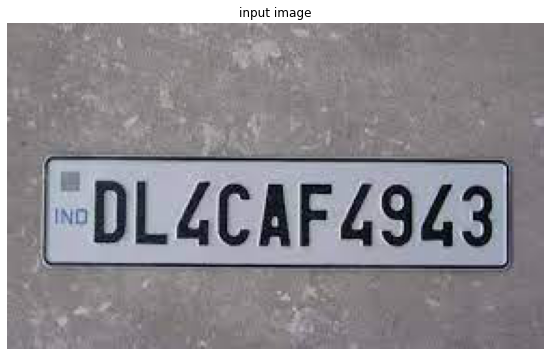

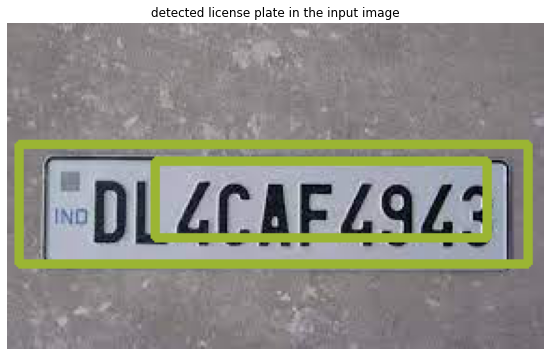

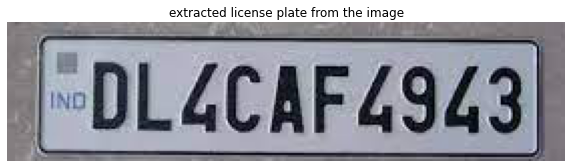

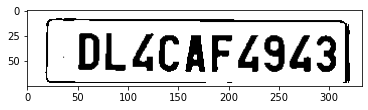

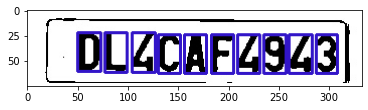

Found 36576 images belonging to 36 classes.
Found 36576 images belonging to 36 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        23248     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        131104    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        131136    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        65600     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 64)          0         
__________________________________

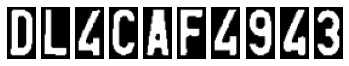

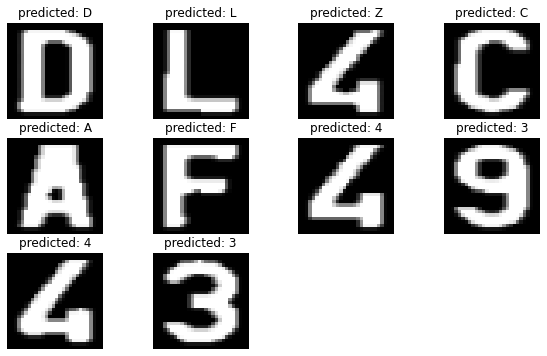

'DLZCAF4343'

In [6]:
path=r'C:\Users\Asus\Dropbox\My PC (LAPTOP-P3LNV77V)\Downloads\download (2).jfif'
PlateRecognition(path)


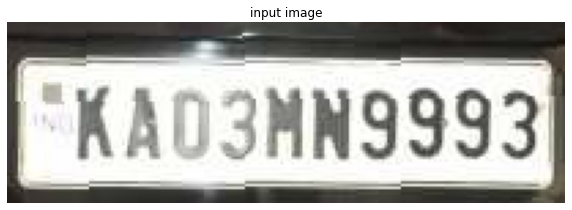

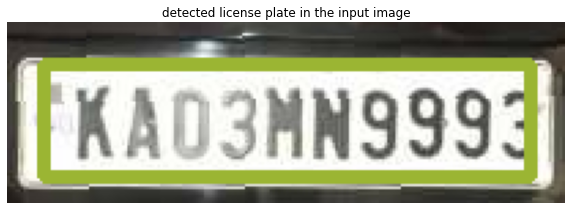

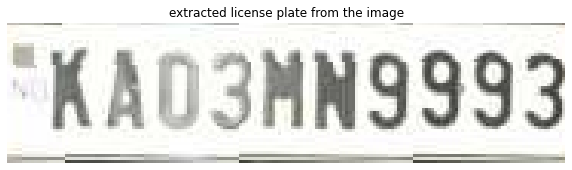

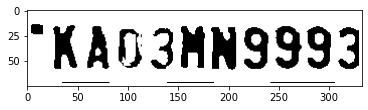

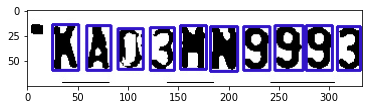

Found 36576 images belonging to 36 classes.
Found 36576 images belonging to 36 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        23248     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        131104    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        131136    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        65600     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 64)          0         
__________________________________

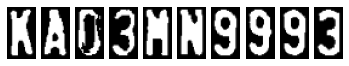

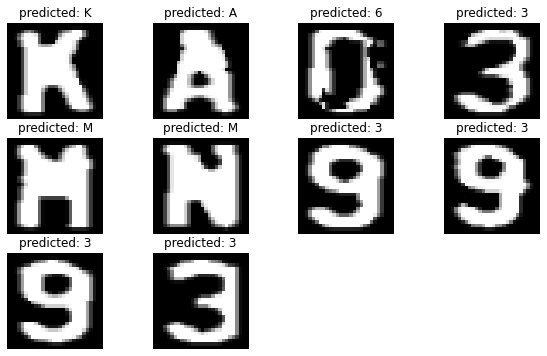

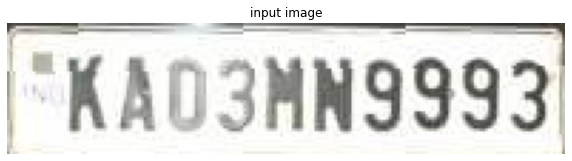

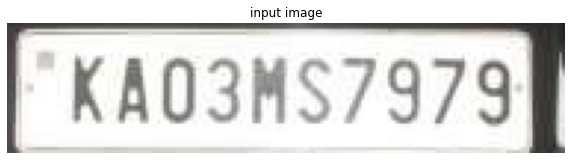

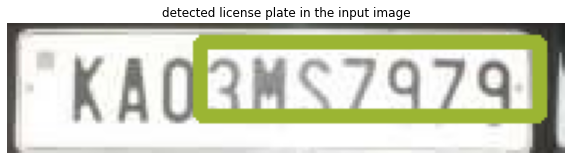

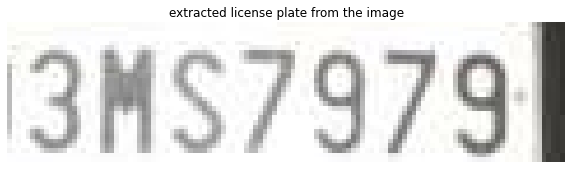

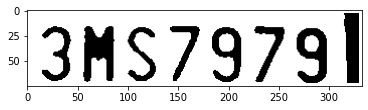

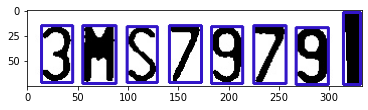

Found 36576 images belonging to 36 classes.
Found 36576 images belonging to 36 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        23248     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        131104    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        131136    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        65600     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 64)          0         
__________________________________

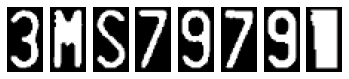

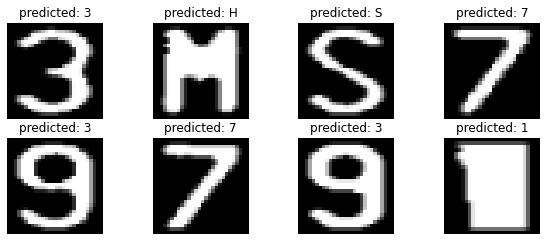

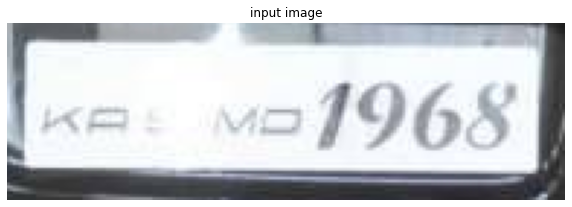

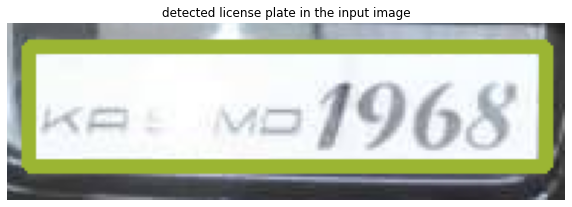

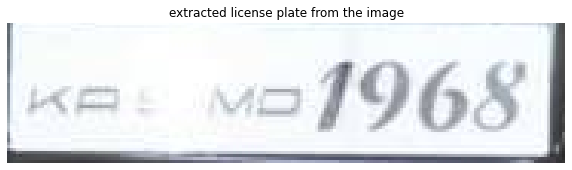

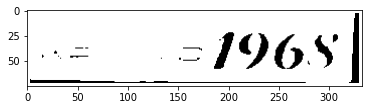

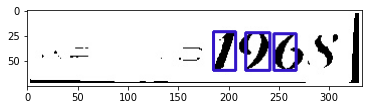

Found 36576 images belonging to 36 classes.
Found 36576 images belonging to 36 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        23248     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        131104    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        131136    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        65600     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 64)          0         
__________________________________

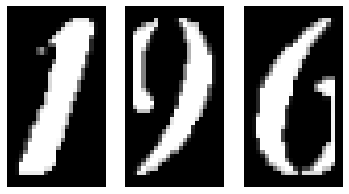

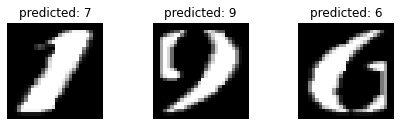

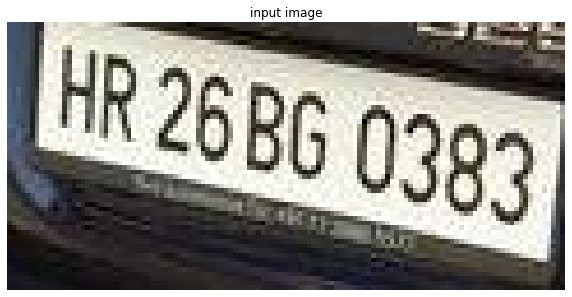

In [8]:
for i in range(5):
    try:
        PlateRecognition(a[i])
    except :
        continue

In [ ]:
# from IPython.display import Image, display

# listOfImageNames = a
# for imageName in listOfImageNames:    
#     display(Image(filename=imageName))